<a href="https://colab.research.google.com/github/dotsnangles/from-keras-to-pytorch-and-more/blob/main/stylegan2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StyleGAN을 활용한 얼굴 이미지 생성

- SytleGAN을 통해 이미지를 생성할 때는 일반적으로 시드 번호를 사용합니다.
- 6600과 같은 정수 시드 번호를 통해 SytleGAN의 Generator가 유니크한 이미지를 생성하도록 합니다.
- 시드는 이미지 생성에 직접적으로 이용되는 잠재 벡터를 생성하는데 사용되며 SytleGAN의 잠재 벡터는 512개의 값들로 이루어집니다.
- 또한, 잠재 벡터에 가하는 변화는 생성 이미지의 변화로 이어지며,
- 잠재 벡터 상의 변화가 아주 작았다고 하더라도 생성 이미지 상의 변화는 상당히 클 수 있습니다.

## 개발 환경 구축

In [1]:
!git clone https://github.com/NVlabs/stylegan3.git
!pip -q install ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 207, done.
remote: Total 207 (delta 0), reused 0 (delta 0), pack-reused 207
Receiving objects: 100% (207/207), 4.17 MiB | 21.36 MiB/s, done.
Resolving deltas: 100% (98/98), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 11.2 MB/s eta 0:00:00


## 모듈 임포트 및 함수 선언

In [2]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, 
         nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs) 
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail("Must specify class label with --class when using "\
            "a conditional network")
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ("warn: --class=lbl ignored when running on "\
            "an unconditional network")
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', 
                   class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(\
      torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

## 생성 모델을 불러옵니다.

In [3]:
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/"\
  "versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...


시드를 통해 잠재 벡터 z를 생성한 뒤 이미지를 생성합니다.

Seed 1000
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


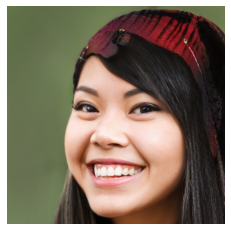

Seed 1001


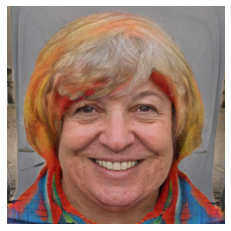

Seed 1002


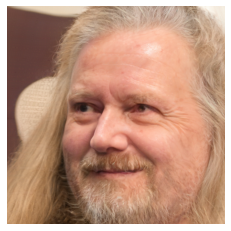

In [4]:
# Choose your own starting and ending seed.
SEED_FROM = 1000
SEED_TO = 1003

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

## 생성 이미지 미세 조정

시드를 통해 생성한 잠재 벡터를 조정함으로써 생성되는 이미지를 미세 조정할 수 있습니다.

In [5]:
START_SEED = 1000

current = seed2vec(G, START_SEED)

선택한 시드를 통해 생성한 이미지를 확인합니다.

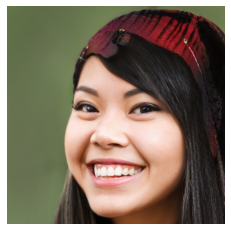

In [6]:
img = generate_image(device, G, current)

display_image(img)

- 미세 조정의 탐색 범위를 설정합니다. EXPLORE_SIZE에 맞춰 잠재 벡터 current와 동일한 shape의 무작위 벡터를 생성합니다. 
- 잠재 벡터 current와 explore에 담긴 각각의 벡터의 합연산을 통해 current를 이동하여 이미지를 생성하는데 사용합니다.
-  z = current - explore[i]

In [7]:
EXPLORE_SIZE = 25

explore = []
for i in range(EXPLORE_SIZE):
  explore.append( np.random.rand(1, 512) - 0.5 )

Direction 0


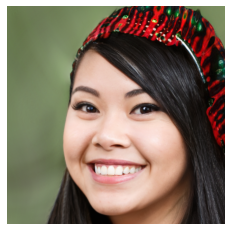

Direction 1


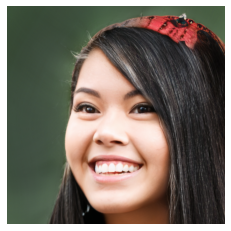

Direction 2


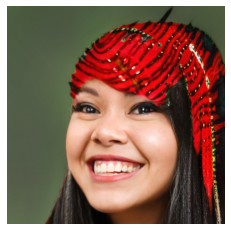

Direction 3


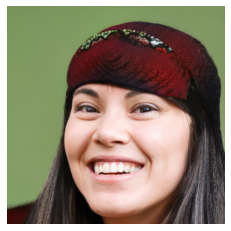

Direction 4


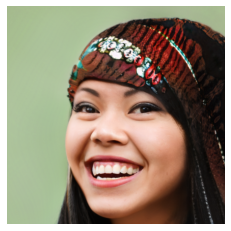

Direction 5


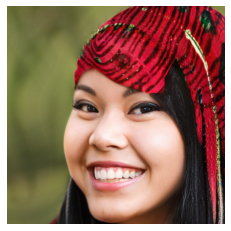

Direction 6


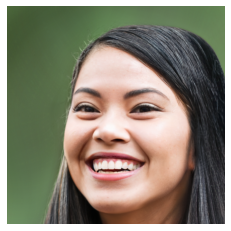

Direction 7


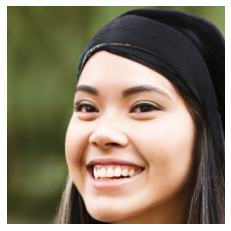

Direction 8


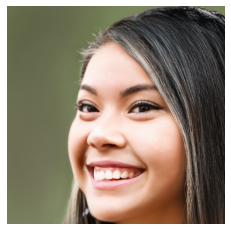

Direction 9


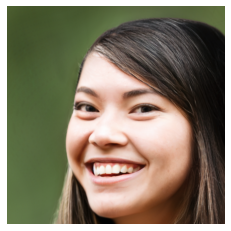

Direction 10


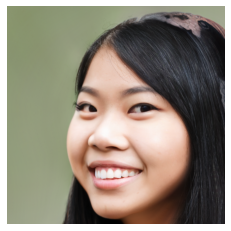

Direction 11


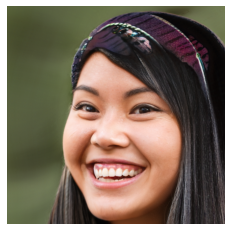

Direction 12


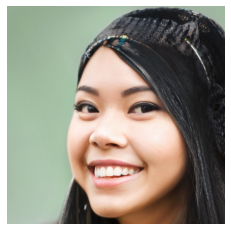

Direction 13


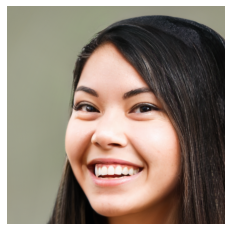

Direction 14


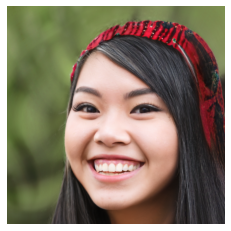

Direction 15


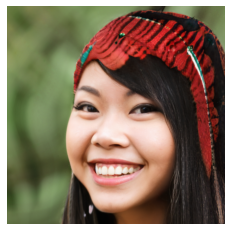

Direction 16


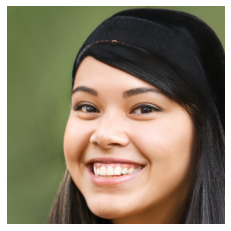

Direction 17


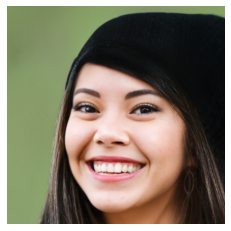

Direction 18


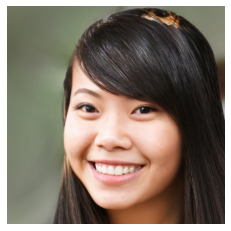

Direction 19


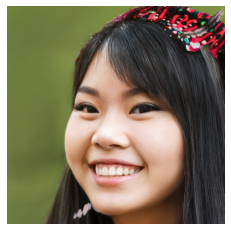

Direction 20


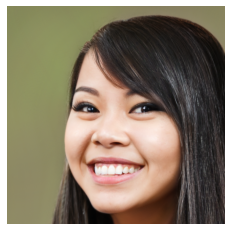

Direction 21


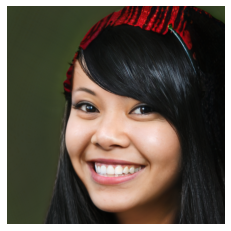

Direction 22


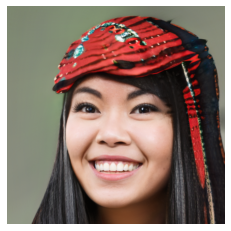

Direction 23


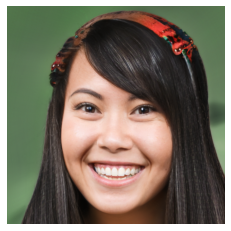

Direction 24


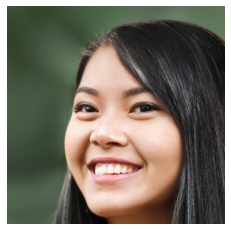

In [8]:
# Choose the direction to move.  Choose -1 for the initial iteration.   
MOVE_DIRECTION = -1

if MOVE_DIRECTION >=0:
  current = current + explore[MOVE_DIRECTION]

for i, mv in enumerate(explore):
  print(f"Direction {i}")
  z = current + mv
  img = generate_image(device, G, z)
  display_image(img)

## 두 잠재 벡터 사이를 촘촘하게 들여다보기

- 하나의 잠재 벡터를 다른 잠재 벡터로 서서히 이동시키며 생성된는 이미지를 살펴보겠습니다.
- 이동 지점을 촘촘하게 만들 수록 이미지가 매끄럽게 변화하는 것을 관찰할 수 있습니다.

![GAN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/gan_progression.jpg "GAN")

- 아래 코드를 사용하여 잠재 벡터 사이의 이동을 살펴볼 수 있는 영상을 생성하겠습니다.
- 3개의 시드를 통해 생성된 잠재 벡터 사이를 100 프레임으로 이동합니다.

In [10]:
# Choose your seeds to morph through and the number of steps to take to get to each.
SEEDS = [6624,6618,6616]
STEPS = 100

# Remove any prior results
!rm /content/results/* 

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(G, SEEDS[i])
  v2 = seed2vec(G, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    img = generate_image(device, G, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

rm: cannot remove '/content/results/*': No such file or directory


Seed 6624:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 6618:   0%|          | 0/100 [00:00<?, ?it/s]

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

아래 코드를 실행하여 다운로드한 뒤 재생해봅니다.

In [11]:
from google.colab import files
files.download('movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# StyleGAN2 훈련

- 구글 드라이브와 코랩을 활용해 훈련을 진행합니다.
- 아래 구글 드라이브를 마운트하고 아래 폴더를 생성해줍니다.

    -  ./data/gan/images - RAW images I wish to train on.
    -  ./data/gan/datasets - Actual training datasets that I convert from the raw images.
    -  ./data/gan/experiments - The output from StyleGAN2, my image previews and saved network snapshots.
- 체크포인트를 구글 드라이브에 저장하며 진행하므로 코랩 연결 시간이 초과되어 연결이 끊어지더라도 후속 훈련을 수행할 수 있습니다.

## 개발 환경 구축

구글 드라이브를 코랩에 마운트합니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /content/drive/MyDrive/data/gan/images
!mkdir -p /content/drive/MyDrive/data/gan/dataset
!mkdir -p /content/drive/MyDrive/data/gan/experiments 

GPU의 정보를 확인합니다.

In [ ]:
!nvidia-smi

Tue Jan  3 01:24:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

개발 환경을 구축합니다.
- 아래 코드를 실행한 뒤 우측의 파일탭을 새로고침하면 /content/pyimgdata와 /content/stylegan2-ada-pytorch가 생성되어 있습니다.
- pyimgdata를 통해 훈련에 필요한 이미지를 크롤링하고 stylegan2-ada-pytorch의 스크립트를 사용해 훈련을 진행합니다.

In [ ]:
!pip install -q torch==1.8.1 torchvision==0.9.1 flickrapi ninja
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!git clone https://github.com/jeffheaton/pyimgdata.git

fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.
fatal: destination path 'pyimgdata' already exists and is not an empty directory.


## Flicker의 이미지를 크롤링하여 StyleGan2의 훈련 데이터로 사용합니다.

- pyimgdata를 활용하여 쉽게 Flicker의 이미지를 다운로드 할 수 있습니다.
- Flickr 계정을 생성하고 API Key와 Secret을 부여받아야 합니다.


다음 페이지에 접속해 API Key를 생성합니다.
- https://www.flickr.com/services/
- Key와 Secret을 각각 하단의 id와 secret에 대입합니다.

/content/pyimgdata/config_flickr.ini 설정이 필요합니다. 변경이 필요한 항목은 다음과 같습니다.
- id / secret / path / search / prefix

```
[FLICKR]
id = [your api id]
secret = [your secret/password]
[Download]
path = /content/drive/MyDrive/data/gan/images
search = christmas decorations
prefix = christmas
update_minutes = 1
license = 0,1,2,3,4,5,6,7,8,9,10
max_download = 100000
sources_file = sources.csv
[Process]
process = True
crop_square = True
min_width = 256
min_height = 256
scale_width = 256
scale_height = 256
image_format = jpg
```

아래 코드를 실행하면 크롤링이 진행됩니다.

In [ ]:
%cd /content/pyimgdata
!python flickr-download.py
%cd /content

## 훈련에 사용시 문제가 있는 이미지가 있는지 확인합니다.

- 모든 이미지는 같은 크기여야 하며 동일한 수의 컬러 채널을 가지고 있어야 합니다.
- 그렇지 않을시 훈련 도중 에러가 발생합니다.

In [ ]:
from os import listdir
from os.path import isfile, join
import os
from PIL import Image
from tqdm.notebook import tqdm

IMAGE_PATH = '/content/drive/MyDrive/data/gan/images'
files = [f for f in listdir(IMAGE_PATH) if isfile(join(IMAGE_PATH, f))]

base_size = None
for file in tqdm(files):
  file2 = os.path.join(IMAGE_PATH,file)
  img = Image.open(file2)
  sz = img.size
  if base_size and sz!=base_size:
    print(f"Inconsistant size: {file2}")
  elif img.mode!='RGB':
    print(f"Inconsistant color format: {file2}")
  else:
    base_size = sz


## 크롤링한 이미지를 활용해 데이터세트를 생성합니다.

In [ ]:
!python /content/stylegan2-ada-pytorch/dataset_tool.py --source /content/drive/MyDrive/data/gan/images --dest /content/drive/MyDrive/data/gan/dataset

## 초기 훈련을 시작합니다.

-  workers 설정이 적용되지 않는 경우 코드블록 실행을 중지 후 다시 시작합니다.
- 코드블록을 재실행했음에도 workers가 코랩의 cpu 코어 갯수인 2개로 설정되지 않는 경우 /content/stylegan2-ada-pytorch/train.py의 108번째 줄의 num_workers를 2로 수정한 뒤 다시 실행합니다.
- train.py를 살펴보면 더 많은 훈련 설정이 가능한 것을 살펴볼 수 있습니다.
- 40tik마다 성능지표인 fid 계산이 이루어집니다. fid가 5 이하인 경우 충분히 훈련이 진행된 것으로 판단할 수 있습니다.
- 코랩 연결이 종료되더라도 체크포인트부터 훈련을 재개할 수 있습니다.

In [ ]:
import os

# Modify these to suit your needs
EXPERIMENTS = "/content/drive/MyDrive/data/gan/experiments"
DATA = "/content/drive/MyDrive/data/gan/dataset"
SNAP = 10
WORKERS = 2

# Build the command and run it
cmd = f"/usr/bin/python3 /content/stylegan2-ada-pytorch/train.py --snap {SNAP} --outdir {EXPERIMENTS} --data {DATA} --workers {WORKERS}"
!{cmd}

## 체크포인트 훈련 재개

In [ ]:
import os

# Modify these to suit your needs
EXPERIMENTS = "/content/drive/MyDrive/data/gan/experiments"
NETWORK = "network-snapshot-000120.pkl"
RESUME = os.path.join(EXPERIMENTS, "00012-dataset-auto1-resumecustom", NETWORK)
DATA = "/content/drive/MyDrive/data/gan/dataset"
SNAP = 10
WORKERS = 2

# Build the command and run it
cmd = f"/usr/bin/python3 /content/stylegan2-ada-pytorch/train.py --snap {SNAP} --resume {RESUME} --outdir {EXPERIMENTS} --data {DATA} --workers {WORKERS}"
!{cmd}

## 생성

In [ ]:
import os

# Modify these to suit your needs

EXPERIMENTS = "/content/drive/MyDrive/data/gan/experiments"
RUN = "00014-dataset-auto1-resumecustom"
NETWORK = os.path.join(EXPERIMENTS, RUN, "network-snapshot-000080.pkl")
OUTDIR = os.path.join(EXPERIMENTS, RUN, 'out')
TRUNCATION = 0.7
SEEDS = '300-305'

# Build the command and run it

cmd = f"/usr/bin/python3 /content/stylegan2-ada-pytorch/generate.py --outdir {OUTDIR} --trunc {TRUNCATION} --seeds {SEEDS} --network {NETWORK}"
!{cmd}

Loading networks from "/content/drive/MyDrive/data/gan/experiments/00014-dataset-auto1-resumecustom/network-snapshot-000080.pkl"...
Generating image for seed 300 (0/6) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for seed 301 (1/6) ...
Generating image for seed 302 (2/6) ...
Generating image for seed 303 (3/6) ...
Generating image for seed 304 (4/6) ...
Generating image for seed 305 (5/6) ...
